In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv('train.dat', sep='\s+', header=None)
test_data = pd.read_table('test.dat', sep='\s+', header=None)

# Rename the columns
train_data.columns = ['yr', 'pop']
test_data.columns = ['yr', 'pop']

# Get the data into X_train, y_train, X_test, y_test using iloc
X_train = train_data.iloc[:,0].values.reshape(-1,1)
y_train = train_data.iloc[:,1].values.reshape(-1,1)

X_test = test_data.iloc[:,0].values.reshape(-1,1)
y_test = test_data.iloc[:,1].values.reshape(-1,1)

In [3]:
# Define the range of kF to consider
kf_range = range(2, 7)

# Create empty lists to store the RMSE for each case and the optimal degree
rmse_list = []
d_star_list = []
kf_rmse_avg_list = []

# Define the range of d to search over
degree_range = range(1, 12)

# Loop over different kF values
for kF in kf_range:
    # Create a KFold object with the current kF value
    kf = KFold(n_splits=kF, shuffle=True, random_state=42)
    
    # Create an empty list to store the RMSE for the current kF
    kF_rmse_list = []
    
    # Loop over the folds of the current kF
    for train_index, val_index in kf.split(X_train):
        # Split the data into training and validation sets for the current fold
        X_kf_train, X_kf_val = X_train[train_index], X_train[val_index]
        y_kf_train, y_kf_val = y_train[train_index], y_train[val_index]
        
        # Create a pipeline that combines StandardScaler() and PolynomialFeatures() classes
        model = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())

        # Create a GridSearchCV object with the pipeline and the parameter grid
        grid_search = GridSearchCV(model, {'polynomialfeatures__degree': degree_range}, cv=6, scoring='neg_mean_squared_error')

        # Fit the grid search object on the training data
        grid_search.fit(X_kf_train, y_kf_train)

        # Get the best hyperparameters from the grid search object
        best_params = grid_search.best_params_
        d_star = best_params['polynomialfeatures__degree']
        # Store the optimal degree for the current fold
        d_star_list.append(d_star)

        # Create a new pipeline with the optimal hyperparameters
        model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=d_star),LinearRegression())

        # Fit the new pipeline on the training data
        model.fit(X_kf_train, y_kf_train)

        # Predict the target variable on the validation set
        y_pred = model.predict(X_kf_val)

        # Extract the coefficient weights of the d∗-degree polynomial learned on all the training data
        coefficients = model.named_steps['polynomialfeatures'].powers_

        # Compute the root mean squared error for the current fold
        kF_rmse_list.append(np.sqrt(mean_squared_error(y_kf_val, y_pred)))

    # Compute the mean RMSE over all folds for the current kF
    mean_rmse = np.mean(kF_rmse_list)

    # Store the mean RMSE for the current kF
    rmse_list.append(mean_rmse)

    # Store the list of RMSEs for the current kF
    kf_rmse_avg_list.append(kF_rmse_list)


In [9]:
#get rmse for each kF
for i in range(len(kf_range)):
    print('RMSE for kF = {}: {:.2f}'.format(kf_range[i], rmse_list[i]))

RMSE for kF = 2: 0.14
RMSE for kF = 3: 0.35
RMSE for kF = 4: 0.13
RMSE for kF = 5: 0.11
RMSE for kF = 6: 0.14


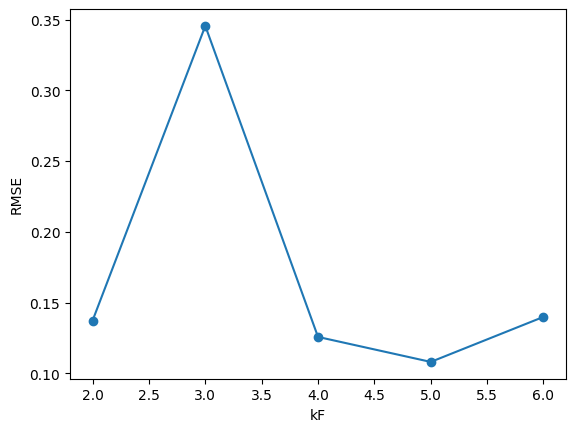

The optimal kF is: 5


In [4]:
# Plot the RMSE for each kF value
plt.plot(kf_range, rmse_list, marker='o')
plt.xlabel('kF')
plt.ylabel('RMSE')
plt.show()

#get the optimal kF
optimal_kF = kf_range[np.argmin(rmse_list)]

print('The optimal kF is: {}'.format(optimal_kF))

In [5]:
#get the optimal d_star
optimal_d_star = d_star_list[np.argmin(rmse_list)]

print('The optimal d* is: {}'.format(optimal_d_star))

The optimal d* is: 8


In [6]:
# Create a new pipeline with the optimal degree d_star_opt 
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=optimal_d_star ),LinearRegression())

# Fit the new pipeline on the training data
model.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = model.predict(X_test)

#Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

# Compute the RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print('The RMSE on the training set is: {}'.format(rmse_train))
print('The RMSE on the test set is: {}'.format(rmse_test))

The RMSE on the training set is: 0.07603457740671474
The RMSE on the test set is: 0.08728845196593196


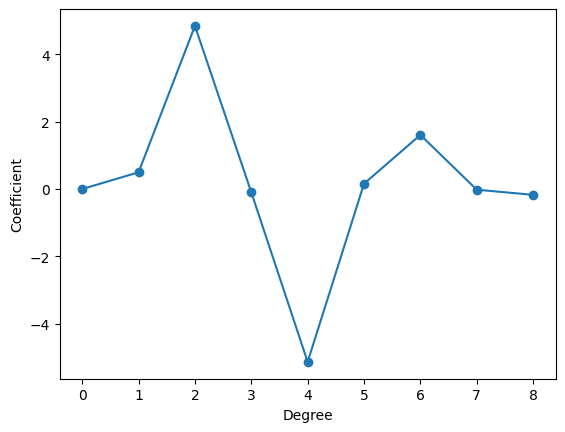

In [7]:
# Extract the coefficient weights of the d∗-degree polynomial learned on all the training data
coefficients = model.named_steps['polynomialfeatures'].powers_

# Plot the coefficients
plt.plot(coefficients[:,0], model.named_steps['linearregression'].coef_[0], marker='o')
plt.xlabel('Degree')
plt.ylabel('Coefficient')
plt.show()

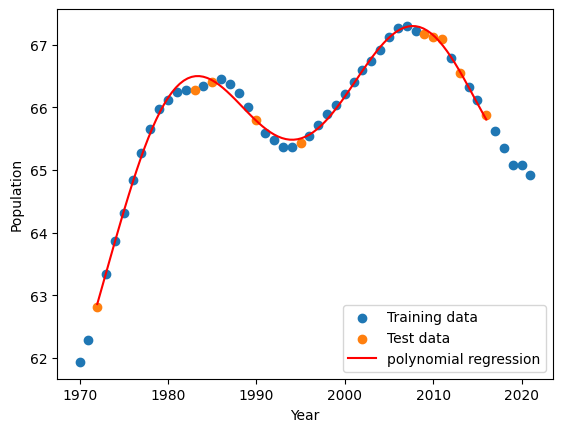

In [8]:
import numpy as np

# Create a range of values to plot the line
x_line = np.linspace(np.min(X_test), np.max(X_test), 100).reshape(-1, 1)

# Predict the target variable for each value in the range
y_line = model.predict(x_line)

# Plot the training and test data
plt.scatter(X_train, y_train, label='Training data')
plt.scatter(X_test, y_test, label='Test data')

# Plot the polynomial regression line
plt.plot(x_line, y_line, color='red', label='polynomial regression')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()

# Show the plot
plt.show()
